In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pytorch_model_summary import summary

**DISCLAIMER**

The presented code is not optimized, it serves an educational purpose. It is written for CPU, it uses only fully-connected networks and an extremely simplistic dataset. However, it contains all components that can help to understand how a Variational Auto-Encoder (VAE) works, and it should be rather easy to extend it to more sophisticated models. This code could be run almost on any laptop/PC, and it takes a couple of minutes top to get the result.

### Dataset

In this example, we go wild and use a dataset that is simpler than MNIST! We use a scipy dataset called Digits. It consists of ~1500 images of size 8x8, and each pixel can take values in $\{0, 1, \ldots, 16\}$.

The goal of using this dataset is that everyone can run it on a laptop, without any gpu etc.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
dataset_path = '../dataset-creator/default-ant/assets/'
actions = np.load(dataset_path + 'actions100k.npy')
observations = np.load(dataset_path + 'observations100k.npy')

labels = np.zeros(len(actions))
labels[100000:200000] = 1
labels[200000:300000] = 2
labels[300000:] = 3
print(actions.shape)
print(actions[0:2])
actions = actions.reshape((len(actions), np.prod(actions.shape[1:])))
observations = observations.reshape((len(observations), np.prod(observations.shape[1:])))

actions = (actions - actions.mean(axis=0)) / actions.std(axis=0)
observations = (observations - observations.mean(axis=0)) / observations.std(axis=0)

print(actions.shape)
print(observations.shape)

data_actions = {'data': actions, 'target': labels}
data_observations = {'data': observations, 'target': labels}


(400000, 1, 8)
[[[-0.19078559 -0.0043949  -0.35682216  0.12354621 -0.15981479
    0.07025298  0.23220053  0.10154168]]

 [[ 0.35320368 -0.48102534 -0.39783162 -0.32131672  0.71288687
    0.04004003  0.09742656  0.00510429]]]
(400000, 8)
(400000, 27)


In [5]:
data_actions['data']

array([[-0.9222673 ,  0.2698223 , -0.75220966, ..., -0.01656062,
         0.5664639 ,  0.15305558],
       [ 1.068601  , -2.2341325 , -0.8460179 , ..., -0.13309732,
         0.25012636, -0.18248734],
       [ 0.4320369 , -0.98491377,  1.1830969 , ..., -0.35046938,
        -1.9217005 ,  1.9785285 ],
       ...,
       [-1.6997393 ,  0.40197113,  0.35525176, ...,  0.612957  ,
         1.4738686 ,  0.02083082],
       [-0.5961721 , -0.43616557,  0.997956  , ...,  0.55298877,
        -0.16593799, -0.05774605],
       [ 0.23876543,  0.90534085,  0.6135678 , ...,  0.4678896 ,
        -0.90086424,  0.11095602]], dtype=float32)

In [6]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        # digits = load_digits()
        digits = data_actions
        # if mode == 'train':
        #     self.data = digits.data[:1000].astype(np.float32)
        # elif mode == 'val':
        #     self.data = digits.data[1000:1350].astype(np.float32)
        # else:
        #     self.data = digits.data[1350:].astype(np.float32)
        if mode == 'train':
            self.data = digits['data'][:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits['data'][1000:1350].astype(np.float32)
        else:
            self.data = digits['data'][1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample
    
    def __getlabel__(self, idx):
        label = self.data['target'][idx]
        return label

### VAE code

Please see the blogpost for details.

**Probability distributions**

In [7]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=4, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

**Encoder**

In [8]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5*log_var)

        eps = torch.randn_like(std)

        return mu + std * eps

    def encode(self, x):
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)

        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log-var and z can`t be None!')

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

**Decoder**

In [9]:
class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()

        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals=num_vals

    def decode(self, z):
        h_d = self.decoder(z)

        if self.distribution == 'categorical':
            b = h_d.shape[0]
            d = h_d.shape[1]//self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            # mu_d = torch.softmax(h_d, 2)
            mu_d = h_d
            return [mu_d]

        elif self.distribution == 'bernoulli':
            mu_d = torch.sigmoid(h_d)
            # return [mu_d]
            return [h_d]
        
        else:
            raise ValueError('Either `categorical` or `bernoulli`')

    def sample(self, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)
            p = mu_d.view(-1, self.num_vals)
            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            x_new = torch.bernoulli(mu_d)
        
        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
            
        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction='sum', dim=-1)
            
        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(z)

**Prior**

In [10]:
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

**Full VAE**

In [11]:
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()

        print('VAE by JT.')

        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals

        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # encoder
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # ELBO
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

### Auxiliary functions: training, evaluation, plotting

It's rather self-explanatory, isn't it?

In [12]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    # plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()
    print(x.shape)
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    # plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    # plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [13]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                # samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Initialize dataloaders

In [14]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

### Hyperparams

In [78]:
D = 8   # input dimension
L = 2  # number of latents
M = 5  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### Initialize VAE

In [79]:
likelihood_type = 'bernoulli'

if likelihood_type == 'categorical':
    num_vals = 4
elif likelihood_type == 'bernoulli':
    num_vals = 1

encoder = nn.Sequential(nn.Linear(D, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, 2 * L))

decoder = nn.Sequential(nn.Linear(L, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, num_vals * D))

prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)

# Print the summary (like in Keras)
print("ENCODER:\n", summary(encoder, torch.zeros(1, D), show_input=False, show_hierarchical=False))
print("\nDECODER:\n", summary(decoder, torch.zeros(1, L), show_input=False, show_hierarchical=False))

VAE by JT.
ENCODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1              [1, 5]              45              45
       LeakyReLU-2              [1, 5]               0               0
          Linear-3              [1, 5]              30              30
       LeakyReLU-4              [1, 5]               0               0
          Linear-5              [1, 4]              24              24
Total params: 99
Trainable params: 99
Non-trainable params: 0
-----------------------------------------------------------------------

DECODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1              [1, 5]              15              15
       LeakyReLU-2              [1, 5]               0               0
          Linear-3              [1, 5]             

### Let's play! Training

In [80]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [81]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=3.3000052097865513
saved!
Epoch: 1, val nll=3.0589755684988837
saved!
Epoch: 2, val nll=2.5516136278424946
saved!
Epoch: 3, val nll=2.58809565952846
Epoch: 4, val nll=2.543524453299386
saved!
Epoch: 5, val nll=1.9662331444876535
saved!
Epoch: 6, val nll=1.6434326716831753
saved!
Epoch: 7, val nll=0.963897032056536
saved!
Epoch: 8, val nll=1.6395787048339843
Epoch: 9, val nll=1.976676265171596
Epoch: 10, val nll=1.3907540784563337
Epoch: 11, val nll=0.5868451581682478
saved!
Epoch: 12, val nll=1.140879603794643
Epoch: 13, val nll=0.627258186340332
Epoch: 14, val nll=0.07297721862792969
saved!
Epoch: 15, val nll=0.5013482230050224
Epoch: 16, val nll=-0.6621408735002791
saved!
Epoch: 17, val nll=-0.5677838516235352
Epoch: 18, val nll=0.11472703116280691
Epoch: 19, val nll=-1.084155455998012
saved!
Epoch: 20, val nll=-1.4391466740199497
saved!
Epoch: 21, val nll=-1.4189253670828683
Epoch: 22, val nll=-0.8459716251918248
Epoch: 23, val nll=-1.8410569763183593
saved!
Epoch:

FINAL LOSS: nll=0.9354475122865883


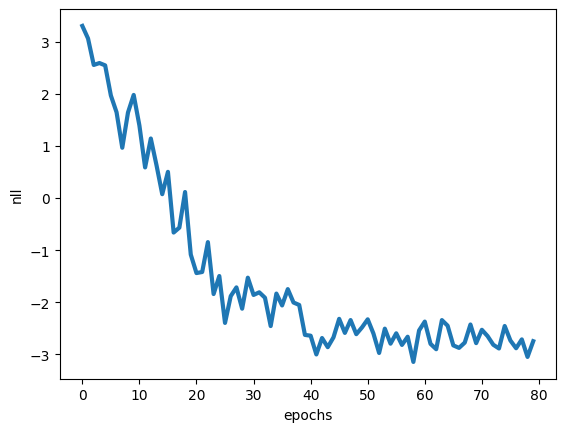

In [82]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

# samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

In [83]:
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()
    print(x.shape)
    for i in range(16):
        print(x[i].shape)
        x = x.reshape((-1, 1, 8))
        plt.scatter(x[:, 0][:, 0], x[:,0][:, 1])
    # fig, ax = plt.subplots(num_x, num_y)
    # for i, ax in enumerate(ax.flatten()):
    #     plottable_image = np.reshape(x[i], 1, 8)
    #     print(plottable_image)
    #     ax.axis('off')
    plt.show()
    # # plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    # plt.close()

(64, 8)
(8,)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)


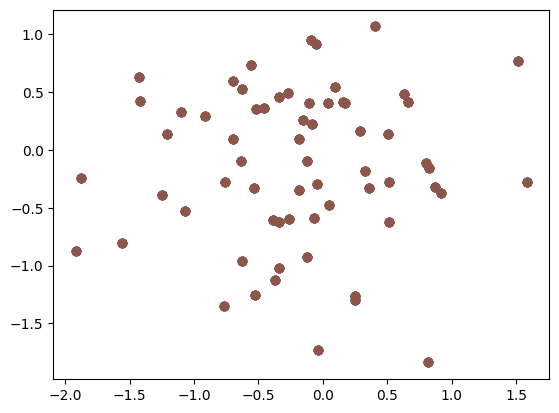

In [84]:
samples_real(result_dir + name, test_loader)

In [85]:

def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 40
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()
    print(x.shape)
    # fig, ax = plt.subplots(num_x, num_y)
    # for i, ax in enumerate(ax.flatten()):
    #     plottable_image = np.reshape(x[i], (8, 8))
    #     ax.imshow(plottable_image, cmap='gray')
    #     ax.axis('off')
    # plt.show()
    # plt.close()

In [86]:
samples_generated('results/'+name, val_loader)

RuntimeError: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [87]:
class LabeledDataset(Dataset):
    """
    A class used to represent labeled dataset
    """
    def __init__(self):
        self.observations = data_actions['data']
        self.labels = data_actions['target']

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.labels[idx]

In [88]:
# Create a LabeledDataset for each set
train_data = LabeledDataset()
valid_data = LabeledDataset()

# Use the LabeledDataset with a DataLoader
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)


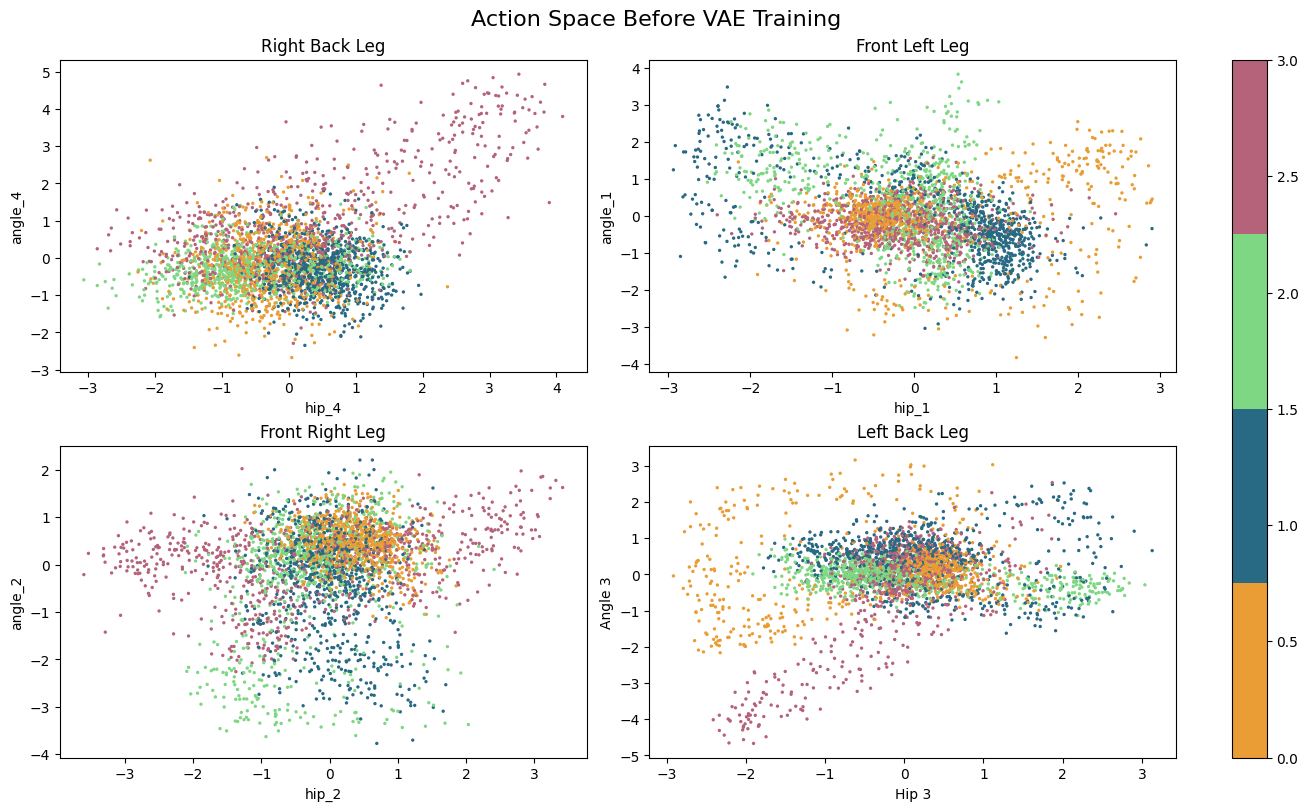

In [89]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#EA9D34', '#286983', '#7ED782', '#B4637A'])

def action_sapce_before():
    fig, ax = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)


    for i, (x, y) in enumerate(dataloader):
        ax[0, 0].scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, s=2)
        ax[0, 0].set_title('Right Back Leg')
        ax[0, 0].set_xlabel('hip_4')
        ax[0, 0].set_ylabel('angle_4')

        ax[0, 1].scatter(x[:, 2], x[:, 3], c=y, cmap=cmap, s=2)
        ax[0, 1].set_title('Front Left Leg')
        ax[0, 1].set_xlabel('hip_1')
        ax[0, 1].set_ylabel('angle_1')

        ax[1, 0].scatter(x[:, 4], x[:, 5], c=y, cmap=cmap, s=2)
        ax[1, 0].set_title('Front Right Leg')
        ax[1, 0].set_xlabel('hip_2')
        ax[1, 0].set_ylabel('angle_2')

        ax[1, 1].scatter(x[:, 6], x[:, 7], c=y, cmap=cmap, s=2)
        ax[1, 1].set_title('Left Back Leg')
        ax[1, 1].set_xlabel('Hip 3')
        ax[1, 1].set_ylabel('Angle 3')

        if i > 100:
            break

    # Add main title
    plt.suptitle('Action Space Before VAE Training', fontsize=16)

    # Add a legend for the whole figure
    fig.colorbar(ax[0, 0].collections[0], ax=ax.ravel().tolist(), pad=0.05)
    
    # plt.savefig('AppoVariations.png', dpi=300)
    plt.show()

action_sapce_before()

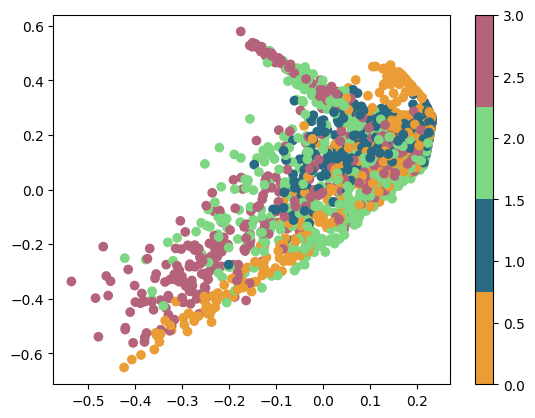

In [90]:
def extract_latents(model, dataloader, num_batches=100):
    # latents = []
    for i, (x, y) in enumerate(dataloader):
        mu, _ = model.encoder.encode(x)
        z = mu.detach().numpy()
        # latents.append(z)
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap=cmap)
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()
    # return np.concatenate(latents)


latents = extract_latents(model, dataloader)


In [91]:
plt.scatter(latents[:, 0][:, 0], latents[:, ])

TypeError: 'NoneType' object is not subscriptable

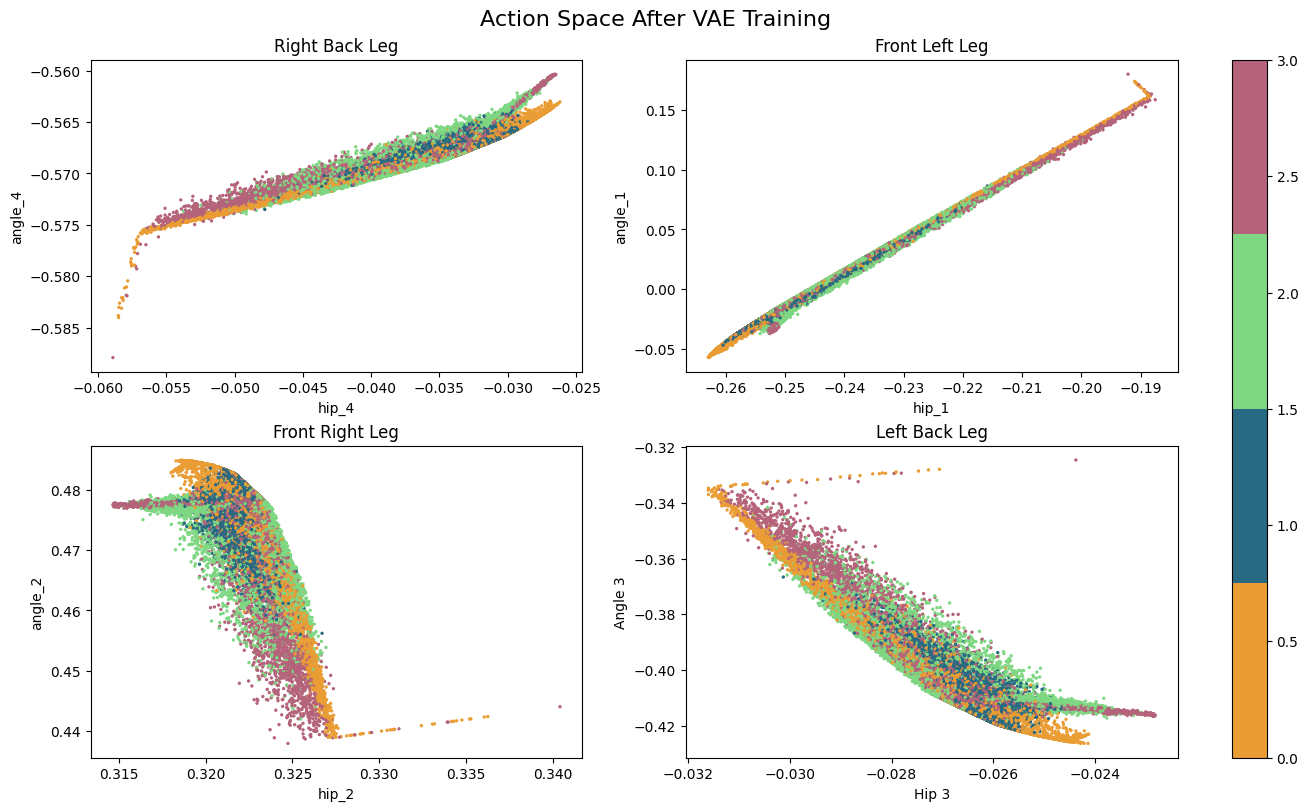

In [92]:
def action_sapce_after(model, num_batches=1000):
    """
    Plot the latent space.
    """
    fig, ax = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)
    res = []
    for i, (x, y) in enumerate(dataloader):
        z, _= model.encoder.encode(x.to(device))
        act = model.decoder.decode(z)
        act = act[0].detach().numpy()
        x = act
        res.append(act)
        x = act.reshape((-1, 1, 8))

        ax[0, 0].scatter(x[:, 0][:, 0], x[:, 0][:, 1], c=y, cmap=cmap, s=2)
        ax[0, 0].set_title('Right Back Leg')
        ax[0, 0].set_xlabel('hip_4')
        ax[0, 0].set_ylabel('angle_4')

        ax[0, 1].scatter(x[:, 0][:, 2], x[:, 0][:, 3], c=y, cmap=cmap, s=2)
        ax[0, 1].set_title('Front Left Leg')
        ax[0, 1].set_xlabel('hip_1')
        ax[0, 1].set_ylabel('angle_1')

        ax[1, 0].scatter(x[:, 0][:, 4], x[:, 0][:, 5], c=y, cmap=cmap, s=2)
        ax[1, 0].set_title('Front Right Leg')
        ax[1, 0].set_xlabel('hip_2')
        ax[1, 0].set_ylabel('angle_2')

        ax[1, 1].scatter(x[:, 0][:, 6], x[:, 0][:, 7], c=y, cmap=cmap, s=2)
        ax[1, 1].set_title('Left Back Leg')
        ax[1, 1].set_xlabel('Hip 3')
        ax[1, 1].set_ylabel('Angle 3')

        
        if i > num_batches:
            break
    # Add main title
    plt.suptitle('Action Space After VAE Training', fontsize=16)

    # Add a legend for the whole figure
    fig.colorbar(ax[0, 0].collections[0], ax=ax.ravel().tolist(), pad=0.05)
    
    # plt.savefig('AppoVariations.png', dpi=300)
    plt.show()
    
    return res
a = action_sapce_after(model)

In [75]:
actions = torch.tensor(actions).float()
z, _= model.encoder.encode(actions)

act = model.decoder.decode(z)
act = act[0].detach().numpy()

/var/folders/w2/w5nbpgdx6x938lygn2q2g4b00000gn/T/ipykernel_64608/103083769.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions).float()


In [76]:
act.shape

(400000, 8)

In [77]:
import gymnasium as gym
env = gym.make("Ant-v4", render_mode="human")
observation, info = env.reset()

for i in range(1000):
    # action = x_test_decoded[i][0]  # agent policy that uses the observation and info
    action = act[0000+i][0:8]
    # observation = observations[i][0]
    _, reward, terminated, truncated, info = env.step(action)
    # observation

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Exception ignored in: <function WindowViewer.__del__ at 0x29d5af740>
Traceback (most recent call last):
  File "/Users/savan/.pyenv/versions/3.11.4/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 335, in __del__
    self.free()
  File "/Users/savan/.pyenv/versions/3.11.4/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "/Users/savan/.pyenv/versions/3.11.4/lib/python3.11/site-packages/glfw/__init__.py", line 1279, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
                              ^^^^^^^^^^^^^^^^^^^^^^
TypeError: _type_ must have storage info
